In [2]:
import numpy as np
import fipy as fp
from fipy import Gmsh2D
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import os
import re
import pdb
import h5py
import pdb

In [3]:
def create_circular_mesh(radius,cellSize):
    """
    Function creates circular 2D mesh

    **Input**

    -   radius   =   Radius of mesh
    -   cellSize    =   Size of unit cell

    *Note* : No support for 3D meshes currently and **requires GMSH**
    """

    mesh = Gmsh2D('''
                     cellSize = %g;
                     radius = %g;
                     Point(1) = {0, 0, 0, cellSize};
                     Point(2) = {-radius, 0, 0, cellSize};
                     Point(3) = {0, radius, 0, cellSize};
                     Point(4) = {radius, 0, 0, cellSize};
                     Point(5) = {0, -radius, 0, cellSize};
                     Circle(6) = {2, 1, 3};


                    Circle(7) = {3, 1, 4};
                    Circle(8) = {4, 1, 5};
                    Circle(9) = {5, 1, 2};
                    Line Loop(10) = {6, 7, 8, 9};
                    Plane Surface(11) = {10};

       '''%(cellSize,radius)) # doctest: +GMSH


    return(mesh)

In [4]:
import ast

def input_parse(filename):
    """
    Parses input files (filename is path to input parameters or param_list file)

    params_flag toggles between input_params vs param_list
    """

    input_parameters  ={}
    with open(filename, 'r') as f:
        count = 0

        for line in f:
            line=line.strip()
            if line:
                if line.find('#') == -1:
                    var_name,var_value = line.split(',')[0],",".join(line.split(',')[1:]) # handle lines with more than 1 comma
                    if var_name != 'output_dir':
                        try:
                            input_parameters[var_name] = float(var_value)
                        except ValueError: # This occurs when python cannot convert list into a float.
                            # Evaluate the python expression as a list
                            input_parameters[var_name] = ast.literal_eval(var_value)
    return input_parameters

In [5]:
nx = 300
dx = 0.1
mesh = create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)

### Dynamics of condensate in the absence of lncRNA

### Rate = $k_p*(\phi_p-0.4)$

IOError: [Errno 2] No such file or directory: '20210610-BURSTING/Bursting_linear_0.4_dynamical_trajectories.svg'

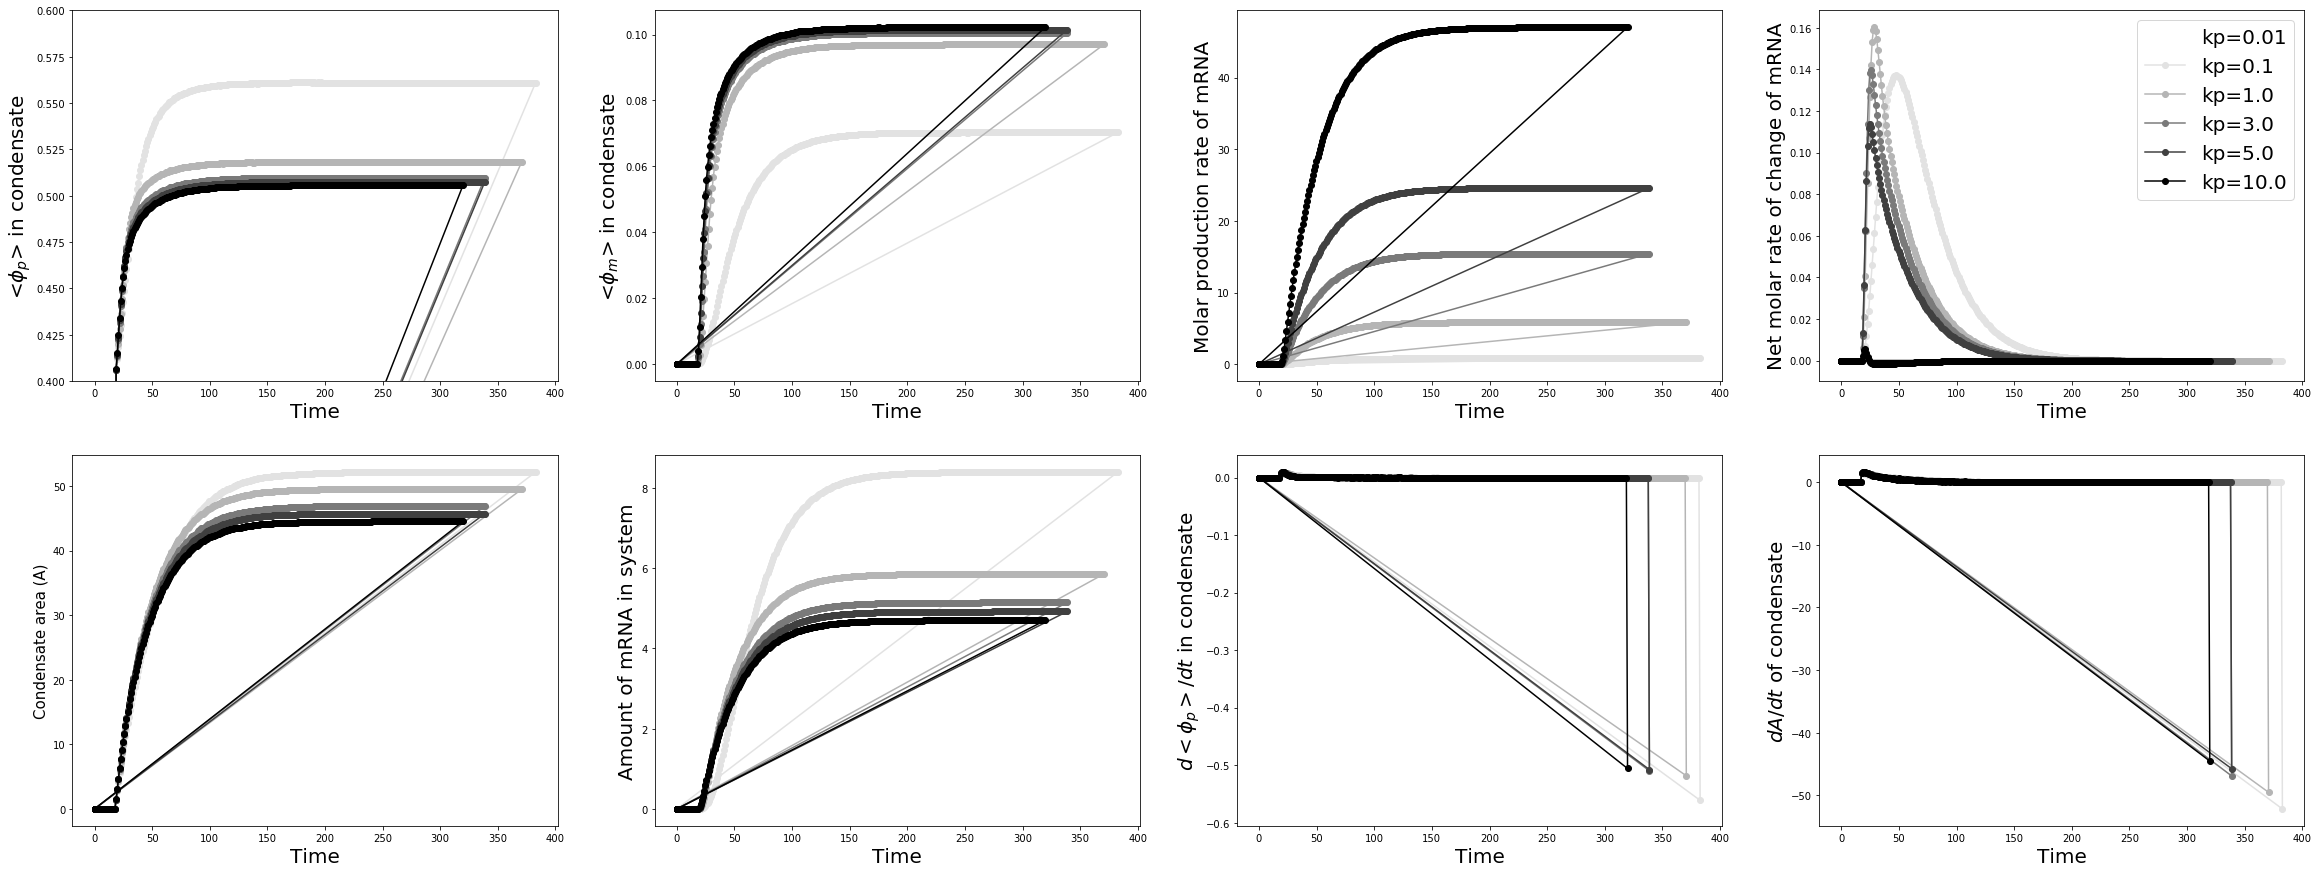

In [8]:
activity_no_lncrna_directory = "/nobackup1c/users/npradeep96/PhaseField/LNCRNA_AND_ACTIVITY/BURSTING/"
kp_list = [0.01,0.1,1.0,3.0,5.0,10.0]

gray_colors = cm.get_cmap('Greys', len(kp_list))
color_values = np.linspace(0,1,len(kp_list))
fig, axs = plt.subplots(2,4,figsize=(40,15))

for i in range(len(kp_list)):
    for root, dirs, files in os.walk(activity_no_lncrna_directory):
        regex = re.compile(r'.*phi_r_.*_L_P_.*_k_p_{}_reactiontype_.*_thresh_.*_FE_.*_rhoc_2.0$'.format(kp_list[i]))
        match = re.search(regex, root)
        if match != None:
            with h5py.File(root + '/dynamical_variables.hdf5') as sp_f: 
                
                axs[0,0].plot(sp_f['t'],sp_f['average_protein_in_condensate'], '-o', c=gray_colors(color_values[i]))
                axs[0,0].set_xlabel('Time', fontsize=20)
                axs[0,0].set_ylabel(r'<$\phi_p$> in condensate', fontsize=20)
                axs[0,0].set_ylim([0.4,0.6])
                
                axs[0,1].plot(sp_f['t'],sp_f['average_mrna_in_condensate'], '-o', c=gray_colors(color_values[i]))
                axs[0,1].set_xlabel('Time', fontsize=20)
                axs[0,1].set_ylabel(r'<$\phi_m$> in condensate', fontsize=20)
                
                axs[0,2].plot(sp_f['t'],sp_f['molar_rate_of_mrna_production'], '-o', c=gray_colors(color_values[i]))
                axs[0,2].set_xlabel('Time', fontsize=20)
                axs[0,2].set_ylabel(r'Molar production rate of mRNA', fontsize=20)
                
                axs[0,3].plot(sp_f['t'],sp_f['net_rate_of_mrna_increase'], '-o', c=gray_colors(color_values[i]), label="kp="+str(kp_list[i]))
                axs[0,3].set_xlabel('Time', fontsize=20)
                axs[0,3].set_ylabel(r'Net molar rate of change of mRNA', fontsize=20)  
                axs[0,3].legend(fontsize=20) 
                
                axs[1,0].plot(sp_f['t'],sp_f['condensate_area'], '-o', c=gray_colors(color_values[i]))
                axs[1,0].set_xlabel('Time', fontsize=20)
                axs[1,0].set_ylabel(r'Condensate area (A)', fontsize=15)
                
                axs[1,1].plot(sp_f['t'],sp_f['total_amount_of_mrna'], '-o', c=gray_colors(color_values[i]))
                axs[1,1].set_xlabel('Time', fontsize=20)
                axs[1,1].set_ylabel(r'Amount of mRNA in system', fontsize=20)
                
                conc_growth_rate = (sp_f['average_protein_in_condensate'][1:]-sp_f['average_protein_in_condensate'][:-1])# *(sp_f['t'][1:]-sp_f['t'][:-1])**(-1)
                conc_growth_rate[conc_growth_rate > 0.05] = 0.0
                axs[1,2].plot(sp_f['t'][:-1], conc_growth_rate, '-o', c=gray_colors(color_values[i]))
                axs[1,2].set_xlabel('Time', fontsize=20)
                axs[1,2].set_ylabel(r'$d<\phi_p>/dt$ in condensate', fontsize=20)
                
                area_growth_rate = (sp_f['condensate_area'][1:]-sp_f['condensate_area'][:-1])# *(sp_f['t'][1:]-sp_f['t'][:-1])**(-1)
                # area_growth_rate[area_growth_rate > 0.0]
                axs[1,3].plot(sp_f['t'][:-1], area_growth_rate, '-o', c=gray_colors(color_values[i]))
                axs[1,3].set_xlabel('Time', fontsize=20)
                axs[1,3].set_ylabel(r'$dA/dt$ of condensate', fontsize=20)

plt.savefig('20210610-BURSTING/Bursting_linear_0.4_dynamical_trajectories.svg', format='svg', dpi=1200)
plt.close()